In [173]:
import pandas as pd
import numpy as np
from requests import get
from pandas import json_normalize
import time
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.metrics import matthews_corrcoef

In [174]:
modeling_data = pd.read_csv('/Users/patricknaylor/Desktop/CA_traffic/Data/selected_columns.csv')

Text(0.5, 1.0, 'Accidents Leading to Deaths In California')

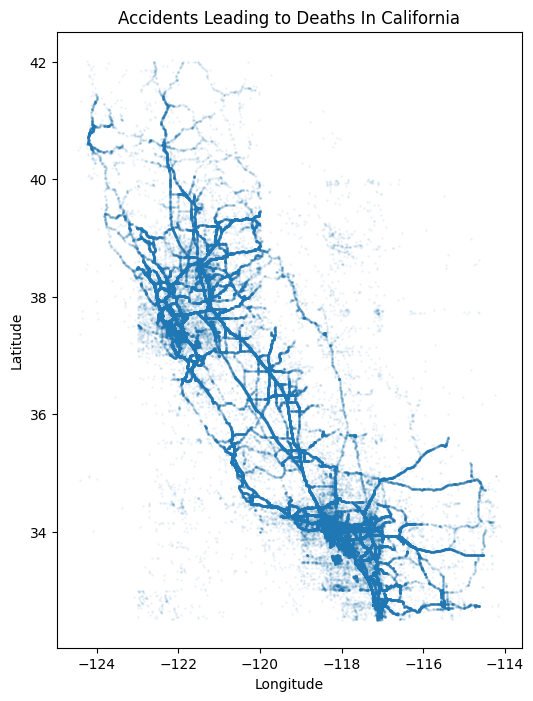

In [216]:
### TODO: Add Major Cities

plt.figure(figsize=(6,8))
plt.scatter(modeling_data['longitude'], modeling_data['latitude'], alpha=.05, s=1)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Accidents Leading to Deaths In California')

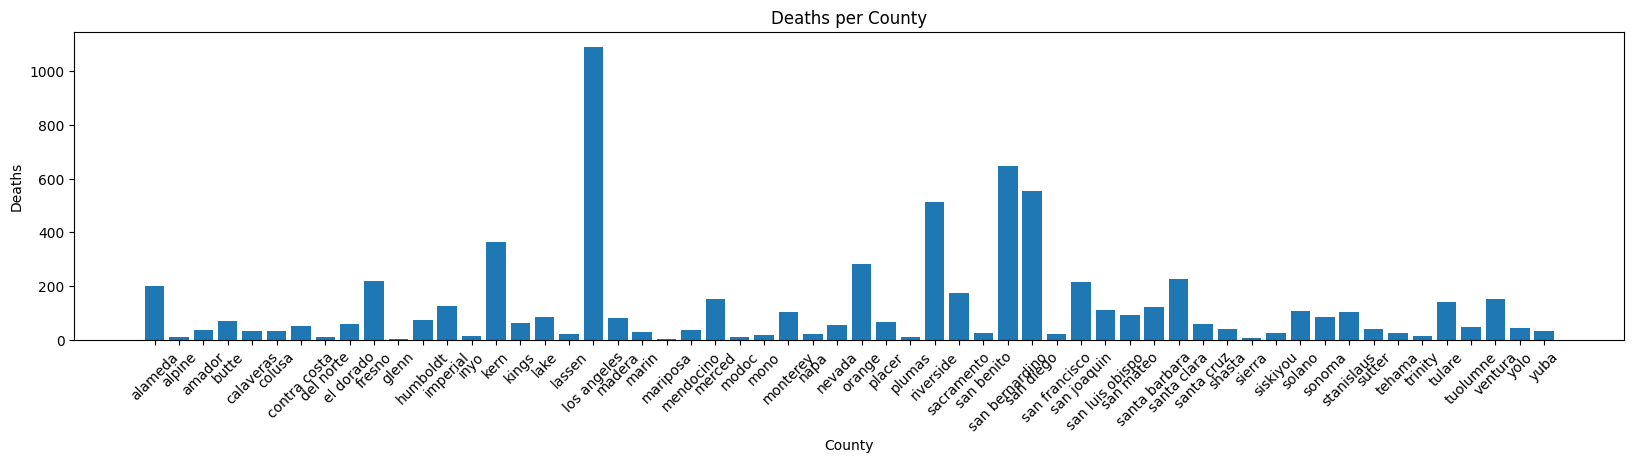

In [219]:
### TODO: Add population on seperate axis and combine
deaths = modeling_data[modeling_data['killed_victims'] > 0]
plt.figure(figsize=(20,4))
plt.bar(deaths.groupby('county_location').count().index.values, deaths.groupby('county_location').sum()['killed_victims'])
plt.xticks(rotation=45)
plt.title('Deaths per County')
plt.xlabel('County')
plt.ylabel('Deaths')
plt.show()

Text(0.5, 1.0, 'Deaths per City Population')

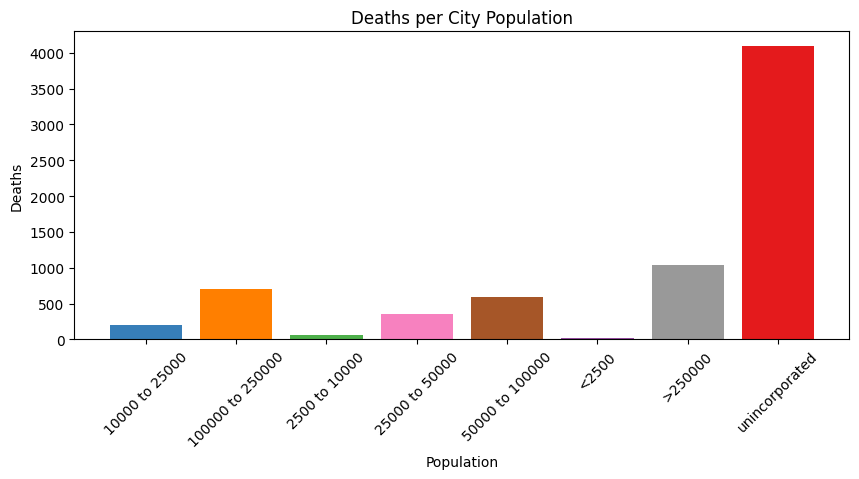

In [221]:
plt.figure(figsize=(10,4))
plt.bar(deaths.groupby('population').count().index.values, deaths.groupby('population').sum()['killed_victims'], color = ['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c'])
plt.xticks(rotation=45)
plt.xlabel('Population')
plt.ylabel('Deaths')
plt.title('Deaths per City Population')

In [155]:
print(modeling_data.nunique())

latitude                           281296
longitude                          315729
statewide_vehicle_type_at_fault        15
alcohol_involved                        2
truck_collision                         2
motorcycle_collision                    2
bicycle_collision                       2
pedestrian_collision                    2
lighting                                5
road_surface                            5
hit_and_run                             3
party_count                            14
injured_victims                        27
killed_victims                          7
location_type                           3
county_location                        58
population                              8
county_location_population             58
dtype: int64


In [156]:
def absolute_maximum_norm(column):
    return column / column.abs().max()

norm_columns = ['latitude', 'longitude', 'county_location_population']

for col in norm_columns:
    modeling_data[col] = absolute_maximum_norm(modeling_data[col])


In [157]:
modeling_data = pd.get_dummies(modeling_data, columns = ['alcohol_involved', 'statewide_vehicle_type_at_fault', 'truck_collision', 'motorcycle_collision', 'bicycle_collision', 'lighting',  'population', 'county_location', 'location_type', 'hit_and_run', 'road_surface'])


In [158]:
modeling_data['mortality_rate'] = modeling_data['killed_victims']/modeling_data['party_count']
modeling_data['injury_rate'] = modeling_data['injured_victims']/modeling_data['party_count']
modeling_data['is_killed'] = modeling_data['killed_victims'] != 0
modeling_data['is_killed'] = modeling_data['is_killed'].astype(int)

In [159]:
columns_list = list(modeling_data.columns)
removals = ['injured_victims', 'killed_victims',  'mortality_rate', 'injury_rate', 'is_killed', 'latitude', 'longitude']
for rem in removals:
    columns_list.remove(rem)
model_x = np.array(modeling_data[columns_list])
model_y = np.array(modeling_data['is_killed'])

In [160]:
X_train, X_test, y_train, y_test = train_test_split(model_x, model_y, test_size=0.33, random_state=0)
x_oversample, y_oversample = resample(X_train[y_train == 1], y_train[y_train == 1], replace=True, n_samples=X_train[y_train ==0].shape[0])
X = np.vstack((X_train[y_train == 0], x_oversample))
y = np.hstack((y_train[y_train == 0], y_oversample))


In [161]:
#rfc = RandomForestClassifier()
#parameters = {'n_estimators': [50, 100, 500], 'max_depth': [2, 5, 10, 30], 'min_samples_split': [2, 5, 10]}
#clf = GridSearchCV(rfc, parameters, verbose=3, n_jobs=4)
#clf.fit(X, y)

In [162]:
best_params_ = {'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 500}

In [163]:
pip = Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(max_iter = 5000))),
  ('classification', RandomForestClassifier(**best_params_))
])
pip.fit(X, y)

Pipeline(steps=[('feature_selection',
                 SelectFromModel(estimator=LinearSVC(max_iter=5000))),
                ('classification',
                 RandomForestClassifier(max_depth=30, n_estimators=500))])

In [170]:
reg = RandomForestClassifier(**best_params_)
reg.fit(X, y)
pred_train = reg.predict(X)
pred_test = reg.predict(X_test)

In [171]:
print(classification_report(y, pred_train))
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.92      0.86      0.89    459801
           1       0.87      0.93      0.90    459801

    accuracy                           0.89    919602
   macro avg       0.90      0.89      0.89    919602
weighted avg       0.90      0.89      0.89    919602

              precision    recall  f1-score   support

           0       0.99      0.86      0.92    226402
           1       0.03      0.47      0.06      2141

    accuracy                           0.85    228543
   macro avg       0.51      0.66      0.49    228543
weighted avg       0.99      0.85      0.91    228543



# TODO:
# split train and test before oversample for more accurate test